# Risk Parity & SG Trend Follower Replication

In [19]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Documents\GitHub\TrendConvexity\src")
from collectData import DataCollector

# Get Data

In [3]:
def get_data() -> pd.DataFrame: 
    
    df_out = (pd.concat([
        DataCollector().collect_futures().rename(columns = {"PX_LAST": "value"}), 
        DataCollector().collect_fx()]))
    
    return df_out

df = get_data()

## SocGen CTA index replication

In this case we are going to replicate the returns from the CTA index. They use a series of futures and currencies. Using this formulation

$\begin{align}
G_t :&= \sum_{k} G_{k,t}\\
    &= \sum_{k} \Pi_{k, t-1} D_{k,t} \\
    &= \lambda \tau \sum_{k} w_k \cdot \mathcal{L}_{\tau}\left(R_{k,t-1} \right) \cdot R_{k,t} 
\end{align}
$

In this case they set $\lambda = 1$ and they set the weights to be $\frac{1}{N}$. Really this is an equal weighting portfolio of EWMA or prior returns using a $\tau = 180$

Recall that the returns are <br>
$\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}\\
\textrm{where}\\
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_\sigma}[D_t^2]}
\end{equation}$
Where $D_t^2$ is daily differenced price

In [4]:
def get_sg_cta() -> pd.DataFrame: 
    
    path   = os.path.join(DataCollector().data_path, "hf_indices.parquet")
    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(security = lambda x: x.security.str.split(" ").str[0]).
        query("security == 'NEIXCTA'").
        set_index("date").
        drop(columns = ["security"]))
    
    return df_out

df_sg = get_sg_cta()

In [5]:
df_signal = (df.pivot(
    index = "date", columns = "security", values = "value").
    diff().
    apply(lambda x: x / (x.ewm(span = 10, adjust = False).std())).
    apply(lambda x: x.ewm(span = 180, adjust = False).mean()))

In [6]:
df_rtn = (df.pivot(
    index = "date", columns = "security", values = "value").
    pct_change())

In [7]:
df_tf_raw_rtn = (
    (np.sign(df_signal.shift()) * df_rtn))

In [8]:
df_scaled_tf_rtn = (df_tf_raw_rtn.apply(
    lambda x: x * (0.20 / (x.ewm(span = 250, adjust = False).std().shift() * np.sqrt(252)))))

In [9]:
df_compared_rtn = (df_scaled_tf_rtn.mean(
    axis = 1).
    to_frame(name = "hf_rtn").
    merge(right = df_sg, how = "inner", on = ["date"]).
    assign(sg_rtn = lambda x: x.PX_LAST.pct_change()).
    drop(columns = ["PX_LAST"]))

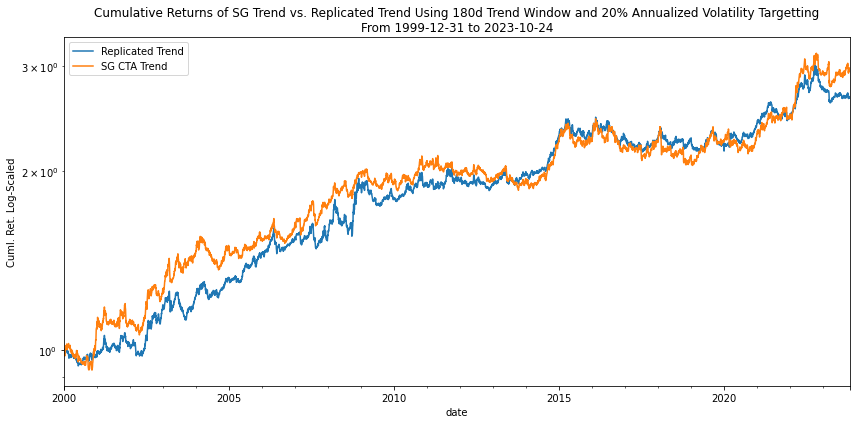

In [10]:
df_plot = (df_scaled_tf_rtn.mean(
    axis = 1).
    to_frame(name = "rtn").
    merge(right = df_sg, how = "inner", on = ["date"]).
    assign(sg_rtn = lambda x: x.PX_LAST.pct_change()).
    drop(columns = ["PX_LAST"]).
    rename(columns = {
        "rtn": "Replicated Trend",
        "sg_rtn": "SG CTA Trend"}).
    apply(lambda x: np.cumprod(1 + x)))

(df_plot.plot(
    figsize = (12,6),
    logy    = True,
    ylabel  = "Cuml. Ret. Log-Scaled",
    title   = "Cumulative Returns of SG Trend vs. Replicated Trend Using 180d Trend Window and 20% Annualized Volatility Targetting\nFrom {} to {}".format(
        df_plot.index.min().date(),
        df_plot.index.max().date())))

plt.tight_layout()

Text(0.5, 1.0, 'Correlation Matrix Between Trend Replication and SG CTA Trend Index')

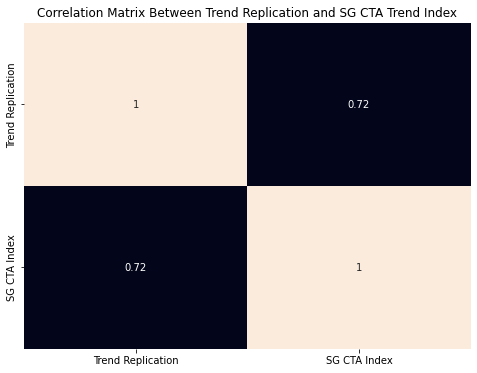

In [26]:
fig, ax = plt.subplots(figsize = (8,6))

sns.heatmap(
    data  = (df_compared_rtn.rename(columns = {
        "hf_rtn": "Trend Replication",
        "sg_rtn": "SG CTA Index"}).
        corr()),
    cbar  = False,
    annot = True,
    ax    = ax)

ax.set_title("Correlation Matrix Between Trend Replication and SG CTA Trend Index")